## Введение в обработку естественного языка
### Урок 8. Рекуррентные нейронные сети RNN LSTM GRU

### Практическое задание  
На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими, необходимо выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара.  
1. построить свёрточные архитектуры
2. построить различные архитектуры с RNN
3. попробовать использовать совместно CNN и RNN
4. сдлать выводы что получилось лучше

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# !pip install stop_words
# !pip install pymorphy2
# !pip install gensim

In [4]:
import time

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Activation, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import callbacks

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Busi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [7]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

### Tensorflow with GPU

In [8]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

### Загрузка данных

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/my_projects/data/train.csv')
# df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/my_projects/data/test.csv')
# df_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/my_projects/data/val.csv')
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_val = pd.read_csv('./data/val.csv')

### Изучение датасета

In [11]:
df_train.head()

,id,text,class
0,0,"@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.",0
1,1,"RT @GalyginVadim: Ребята и девчата!\nВсе в кино!!! ""Вот Это Любовь!""\nСегодня! Завтра! И потом!)))))\n#вотэтолюбовь",1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретвит((((( RT,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Запретный плод. :),1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса не боится мороза и .......)),1


In [12]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не получилось(( ну и хрен с ним"
2,204152,"Хочу лето только ради того, что бы направить ногти ярким лаком :)"
3,204153,"RT @RonyLiss: @colf_ne блин((\nа я шипперила ФлораБлум\nИ МузаТекна\nА Стеллу.. не помню, ахах"
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое воскресенье утром выходит:( а сегодня ..какашка:(просто я иду человека фоткать и мне нужно солн…"


In [13]:
df_val.head()

,id,text,class
0,181467,RT @TukvaSociopat: Максимальный репост! ))) #євромайдан http://t.co/wxtQ0xGVtp,1
1,181468,"чтоб у меня з.п. ежегодно индексировали на индекс инфляции, как тарифы на автобусы! :(",0
2,181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
3,181470,"@inafish нее , когда ногами ахахах когда?ахаха честн не помню , я тебе завтра в шк покажу как меня прикона пиздят ~((((",0
4,181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


In [14]:
df_train.tail()

,id,text,class
181462,181462,Классным будет новый год..( http://t.co/LejaGuXNwu,0
181463,181463,Видишь человека хочешь сказать ему привет . А он тебя игнорит :(,0
181464,181464,@Julia6_9Styles там длинный диагноз. Вкратце: аллергический отёк горла с осложнением в виде фолликулярной ангины :(,0
181465,181465,"@technoslav ух ты, а кому тот серенький кнопочне телефон достанется ;)",1
181466,181466,"@Kris1D_07 я тоже так собираюсь сделать:D навешаю фоток вандюх:D \nобязательно выложи фотку, как нарядишь:3",1


In [15]:
df_test.tail()

,id,text
22679,226829,"RT @NickValuev: Небоскребы, небоскребы, а я маленький такой:) http://t.co/ZJ3H12KPPK"
22680,226830,"Первый день в школе в новом году;( 3 человека спросили: все ли у меня в порядке?.. Черный я любою, вот и все"
22681,226831,RT @Killgay_slut: @Your_Novocaine привеееет муда... какой к черту Сэмми? (
22682,226832,"Настроение вроде нормальное, но от чего плакать хочется("
22683,226833,"зашла перед сном к девчонкам)пока они мыли посуду,Настя фоткалась) http://t.co/kiNexuDTuh"


In [16]:
df_val.tail()

,id,text,class
22678,204145,А я знаю из-за кого такая паршивая погода была сегодня))),1
22679,204146,ааа.... что с Гмейлом. не ужто он умер сегодня :( именно в тот день когда мне надо сдавать журнал в печать,0
22680,204147,"в учебники химии написано ""Пруст Жозеф Луи""\nя явно подумала не о том Жозефе и не о том Луи:DD",1
22681,204148,"Вот все любят,а я не люблю..как дура..говорю,что люблю..а сама..(",0
22682,204149,"уххх спасибо дорогой Леле Евгеньевне и Штепуху за сегодняшний все было очень круто ,ну как обычно )))) нас даже научили как готовить бутеры",1


In [17]:
print(df_train.shape, df_test.shape, df_val.shape)

(181467, 3) (22684, 2) (22683, 3)


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181467 entries, 0 to 181466
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      181467 non-null  int64 
 1   text    181467 non-null  object
 2   class   181467 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ MB


In [19]:
df_train.isnull().sum()

id       0
text     0
class    0
dtype: int64

In [20]:
df_test.isnull().sum()

id      0
text    0
dtype: int64

In [21]:
df_val.isnull().sum()

id       0
text     0
class    0
dtype: int64

### Предобработка

In [22]:
sw = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [23]:
def preprocess_reviews(reviews):
    reviews = str(reviews)
    reviews = ''.join(c for c in reviews if c not in exclude)
    reviews = reviews.lower()
    reviews = re.sub("\sне", "не", reviews)
    reviews = [morpher.parse(word)[0].normal_form for word in reviews.split() if word not in sw]
    return " ".join(reviews)

In [24]:
df_train['text'] = df_train['text'].apply(preprocess_reviews)
df_test['text'] = df_test['text'].apply(preprocess_reviews)
df_val['text'] = df_val['text'].apply(preprocess_reviews)

In [25]:
df_train.head(3)

,id,text,class
0,0,alisachachkaич уезжаааааааать ❤ тожена хотеть уезжать,0
1,1,rt galyginvadim ребята девчата кино любовь завтра вотэтолюбовь,1
2,2,rt artemklyushin ктоненавидеть пробка ретвит rt,0


In [26]:
df_test.head(3)

,id,text
0,204150,тектоника рельефсамый ужасный мир мучение
1,204151,ходить запускать шар желание насна получиться хрен они
2,204152,хотеть лето ради направить ноготь яркий лак


In [27]:
df_val.head(3)

,id,text,class
0,181467,rt tukvasociopat максимальный репост євромайдан httptcowxtq0xgvtp,1
1,181468,зп ежегодно индексировать индекс инфляция тариф автобус,0
2,181469,chilyandlimeнеховать мнен,0


### 0. Baseline

In [28]:
X_train = df_train['text']
y_train = df_train['class']
X_test = df_val['text']
y_test = df_val['class']

In [29]:
# # labelEncode целевую переменную
# encoder = preprocessing.LabelEncoder()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.fit_transform(y_test)

In [30]:
models = []

models.append(('CountVectorizer_LR', CountVectorizer()))
models.append(('TfidfVectorizer_LR', TfidfVectorizer()))
models.append(('HashingVectorizer_LR', HashingVectorizer()))

In [31]:
# Logistic Regression
start_time = time.time()
classifier = linear_model.LogisticRegression()

results = []

for name, model in models:
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)

    results.append((name, train_accuracy, test_accuracy))
    
baseline_lr = pd.DataFrame(results, columns = ['model', 'train_accuracy', 'test_accuracy'])
baseline_lr.sort_values('test_accuracy', ascending=False)
lr_time = (time.time() - start_time)

In [32]:
lr_time

41.84994721412659

In [33]:
models = []

models.append(('CountVectorizer_LSVC', CountVectorizer()))
models.append(('TfidfVectorizer_LSVC', TfidfVectorizer()))
models.append(('HashingVectorizer_LSVC', HashingVectorizer()))

In [34]:
# LinearSVC
start_time = time.time()
classifier = LinearSVC()

results = []

for name, model in models:
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)

    results.append((name, train_accuracy, test_accuracy))
    
baseline_lsvc = pd.DataFrame(results, columns = ['model', 'train_accuracy', 'test_accuracy'])
baseline_lsvc.sort_values('test_accuracy', ascending=False)
lsvc_time = (time.time() - start_time)

In [35]:
lsvc_time

47.59124708175659

### Word Embeddings

In [36]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [38]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1 # Adding 1 because of reserved 0 index
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [39]:
y_train = df_train['class'].values
y_val = df_val['class'].values

### Simple model

In [40]:
# Training
epochs = 5
batch_size = 64

In [41]:
input_dim = X_train.shape[1]  # Number of features

In [42]:
model_1 = Sequential([
    layers.Dense(10, input_dim=input_dim, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [43]:
model_1.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [44]:
start_time = time.time()
history_1 = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time1 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 3s 855us/step - loss: 2356.3279 - accuracy: 0.5111 - val_loss: 36.3851 - val_accuracy: 0.5209
Epoch 2/5
2836/2836 [==============================] - 2s 761us/step - loss: 90.6616 - accuracy: 0.5257 - val_loss: 24.1318 - val_accuracy: 0.5173
Epoch 3/5
2836/2836 [==============================] - 2s 729us/step - loss: 71.6450 - accuracy: 0.5263 - val_loss: 22.0210 - val_accuracy: 0.5295
Epoch 4/5
2836/2836 [==============================] - 2s 740us/step - loss: 71.2998 - accuracy: 0.5245 - val_loss: 34.7786 - val_accuracy: 0.5070
Epoch 5/5
2836/2836 [==============================] - 2s 753us/step - loss: 65.8947 - accuracy: 0.5329 - val_loss: 27.1938 - val_accuracy: 0.5244


In [45]:
model_time1

11.403963565826416

In [46]:
score_train1 = model_1.evaluate(X_train, y_train, verbose=0)
score_test1 = model_1.evaluate(X_valid, y_val, verbose=0)

In [47]:
print('Train loss:', score_train1[0])
print('Train accuracy:', score_train1[1])
print('Test loss:', score_test1[0])
print('Test accuracy:', score_test1[1])

Train loss: 59.77468490600586
Train accuracy: 0.5263161063194275
Test loss: 27.193832397460938
Test accuracy: 0.52448970079422


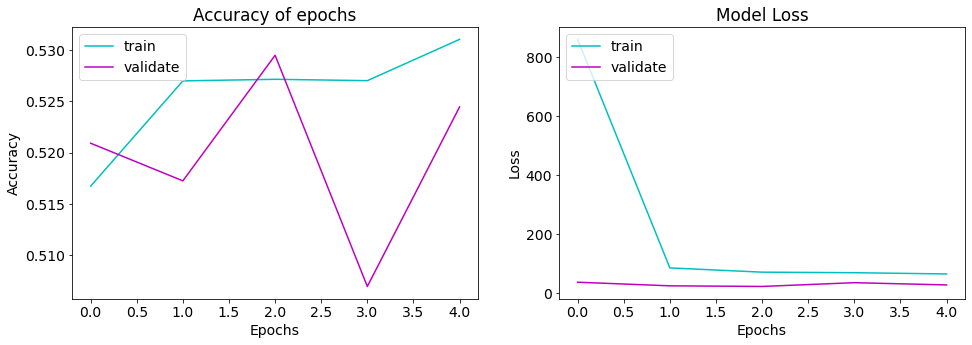

In [48]:
plot_model(history_1)

In [49]:
result_1 = pd.DataFrame((score_train1[1], score_test1[1], score_train1[0], score_test1[0])).T
result_1.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_1['model'] = 'Simple model'

### Embedding Layer

In [51]:
embedding_dim = 50

In [52]:
model_2 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Flatten(),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [53]:
model_2.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [54]:
start_time = time.time()
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time2 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 418s 147ms/step - loss: 0.5650 - accuracy: 0.6893 - val_loss: 0.4958 - val_accuracy: 0.7496
Epoch 2/5
2836/2836 [==============================] - 478s 169ms/step - loss: 0.2271 - accuracy: 0.9128 - val_loss: 0.6200 - val_accuracy: 0.7323
Epoch 3/5
2836/2836 [==============================] - 444s 156ms/step - loss: 0.0549 - accuracy: 0.9809 - val_loss: 0.8680 - val_accuracy: 0.7171
Epoch 4/5
2836/2836 [==============================] - 413s 146ms/step - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.9871 - val_accuracy: 0.7141
Epoch 5/5
2836/2836 [==============================] - 444s 156ms/step - loss: 0.0126 - accuracy: 0.9958 - val_loss: 1.1439 - val_accuracy: 0.7109


In [55]:
model_time2

2196.6105494499207

In [56]:
score_train2 = model_2.evaluate(X_train, y_train, verbose=0)
score_test2 = model_2.evaluate(X_valid, y_val, verbose=0)

In [57]:
print('Train loss:', score_train2[0])
print('Train accuracy:', score_train2[1])
print('Test loss:', score_test2[0])
print('Test accuracy:', score_test2[1])

Train loss: 0.006961461156606674
Train accuracy: 0.9979224801063538
Test loss: 1.1439180374145508
Test accuracy: 0.7108848094940186


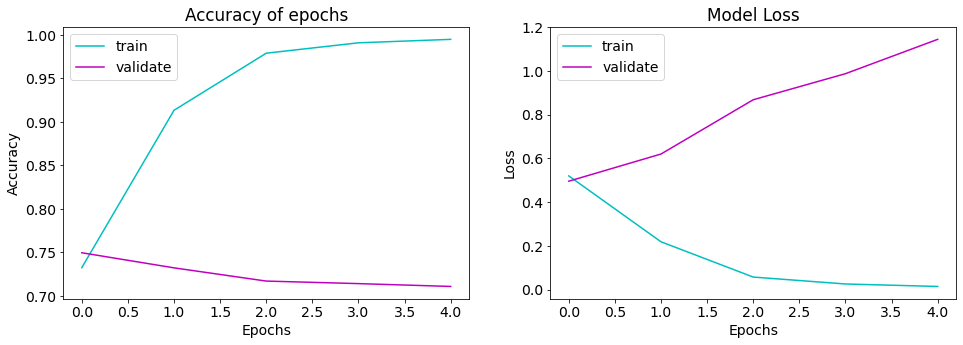

In [58]:
plot_model(history_2)

In [59]:
result_2 = pd.DataFrame((score_train2[1], score_test2[1], score_train2[0], score_test2[0])).T
result_2.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_2['model'] = 'Embedding Layer'

### Add GlobalMaxPool1D

In [60]:
model_3 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.GlobalMaxPool1D(),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [61]:
model_3.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [62]:
start_time = time.time()
history_3 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time3 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 479s 169ms/step - loss: 0.0100 - accuracy: 0.9967 - val_loss: 1.2728 - val_accuracy: 0.7076
Epoch 2/5
2836/2836 [==============================] - 441s 155ms/step - loss: 0.0068 - accuracy: 0.9976 - val_loss: 1.4271 - val_accuracy: 0.7041
Epoch 3/5
2836/2836 [==============================] - 416s 147ms/step - loss: 0.0049 - accuracy: 0.9983 - val_loss: 1.5420 - val_accuracy: 0.7001
Epoch 4/5
2836/2836 [==============================] - 413s 146ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 1.6844 - val_accuracy: 0.6957
Epoch 5/5
2836/2836 [==============================] - 469s 166ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 1.7464 - val_accuracy: 0.6989


In [63]:
model_time3

2217.8602900505066

In [64]:
score_train3 = model_3.evaluate(X_train, y_train, verbose=0)
score_test3 = model_3.evaluate(X_valid, y_val, verbose=0)

In [65]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6932280659675598
Train accuracy: 0.485206663608551
Test loss: 0.6932350993156433
Test accuracy: 0.48604682087898254


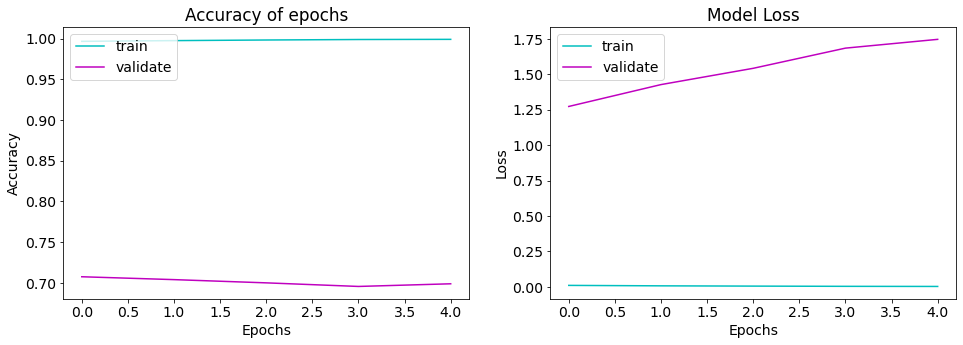

In [66]:
plot_model(history_3)

In [67]:
result_3 = pd.DataFrame((score_train3[1], score_test3[1], score_train3[0], score_test3[0])).T
result_3.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_3['model'] = 'Add GlobalMaxPool1D'

### Convolutional Neural Networks (CNN)

In [52]:
embedding_dim = 100

In [69]:
model_4 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [70]:
model_4.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [71]:
start_time = time.time()
history_4 = model_4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time4 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 918s 324ms/step - loss: 0.5532 - accuracy: 0.7020 - val_loss: 0.4939 - val_accuracy: 0.7478
Epoch 2/5
2836/2836 [==============================] - 904s 319ms/step - loss: 0.1994 - accuracy: 0.9222 - val_loss: 0.6523 - val_accuracy: 0.7274
Epoch 3/5
2836/2836 [==============================] - 906s 319ms/step - loss: 0.0405 - accuracy: 0.9866 - val_loss: 0.9026 - val_accuracy: 0.7268
Epoch 4/5
2836/2836 [==============================] - 895s 316ms/step - loss: 0.0127 - accuracy: 0.9959 - val_loss: 1.1962 - val_accuracy: 0.7288
Epoch 5/5
2836/2836 [==============================] - 947s 334ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 1.4130 - val_accuracy: 0.7204


In [72]:
model_time4

4570.4806163311005

In [73]:
score_train4 = model_4.evaluate(X_train, y_train, verbose=0)
score_test4 = model_4.evaluate(X_valid, y_val, verbose=0)

In [74]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6932280659675598
Train accuracy: 0.485206663608551
Test loss: 0.6932350993156433
Test accuracy: 0.48604682087898254


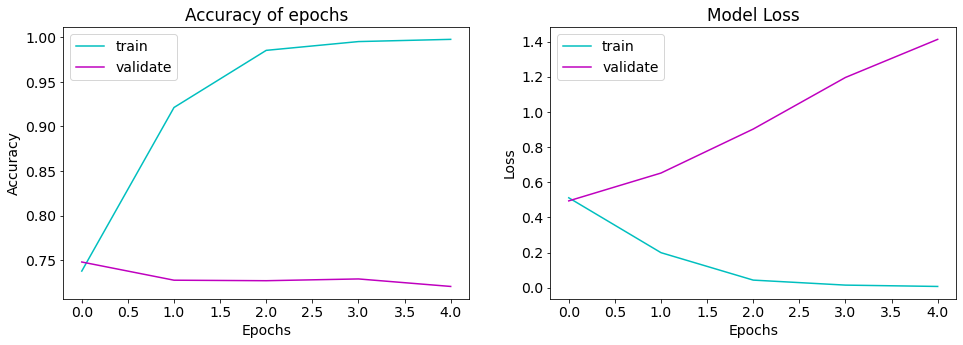

In [75]:
plot_model(history_4)

In [76]:
result_4 = pd.DataFrame((score_train4[1], score_test4[1], score_train4[0], score_test4[0])).T
result_4.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_4['model'] = 'CNN'

### Add Dropout

In [77]:
model_5 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [78]:
model_5.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [79]:
start_time = time.time()
history_5 = model_5.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time5 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 940s 331ms/step - loss: 0.5676 - accuracy: 0.6895 - val_loss: 0.5091 - val_accuracy: 0.7428
Epoch 2/5
2836/2836 [==============================] - 952s 336ms/step - loss: 0.2551 - accuracy: 0.8997 - val_loss: 0.5976 - val_accuracy: 0.7441
Epoch 3/5
2836/2836 [==============================] - 955s 337ms/step - loss: 0.0749 - accuracy: 0.9754 - val_loss: 0.8258 - val_accuracy: 0.7387
Epoch 4/5
2836/2836 [==============================] - 839s 296ms/step - loss: 0.0315 - accuracy: 0.9901 - val_loss: 1.0705 - val_accuracy: 0.7357
Epoch 5/5
2836/2836 [==============================] - 867s 306ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 1.1776 - val_accuracy: 0.7197


In [80]:
model_time5

4552.411277294159

In [81]:
score_train5 = model_5.evaluate(X_train, y_train, verbose=0)
score_test5 = model_5.evaluate(X_valid, y_val, verbose=0)

In [82]:
print('Train loss:', score_train3[0])
print('Train accuracy:', score_train3[1])
print('Test loss:', score_test3[0])
print('Test accuracy:', score_test3[1])

Train loss: 0.6932280659675598
Train accuracy: 0.485206663608551
Test loss: 0.6932350993156433
Test accuracy: 0.48604682087898254


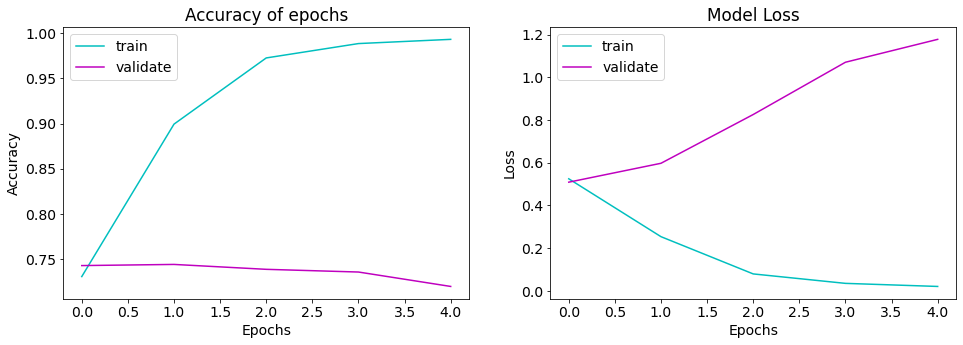

In [83]:
plot_model(history_5)

In [84]:
result_5 = pd.DataFrame((score_train5[1], score_test5[1], score_train5[0], score_test5[0])).T
result_5.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_5['model'] = 'Add Dropout'

### CNN + LSTM

In [87]:
model_6 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.LSTM(64),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [88]:
model_6.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [89]:
start_time = time.time()
history_6 = model_6.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time6 = (time.time() - start_time)

Epoch 1/5
2836/2836 [==============================] - 922s 325ms/step - loss: 0.5594 - accuracy: 0.7010 - val_loss: 0.4985 - val_accuracy: 0.7505
Epoch 2/5
2836/2836 [==============================] - 868s 306ms/step - loss: 0.2374 - accuracy: 0.9063 - val_loss: 0.5928 - val_accuracy: 0.7349
Epoch 3/5
2836/2836 [==============================] - 817s 288ms/step - loss: 0.0717 - accuracy: 0.9752 - val_loss: 0.9828 - val_accuracy: 0.7318
Epoch 4/5
2836/2836 [==============================] - 815s 287ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 1.0672 - val_accuracy: 0.7279
Epoch 5/5
2836/2836 [==============================] - 813s 287ms/step - loss: 0.0171 - accuracy: 0.9942 - val_loss: 1.3145 - val_accuracy: 0.7186


In [90]:
model_time6

4234.83891415596

In [91]:
score_train6 = model_6.evaluate(X_train, y_train, verbose=0)
score_test6 = model_6.evaluate(X_valid, y_val, verbose=0)

In [92]:
print('Train loss:', score_train6[0])
print('Train accuracy:', score_train6[1])
print('Test loss:', score_test6[0])
print('Test accuracy:', score_test6[1])

Train loss: 0.008386129513382912
Train accuracy: 0.9970187544822693
Test loss: 1.3144868612289429
Test accuracy: 0.718555748462677


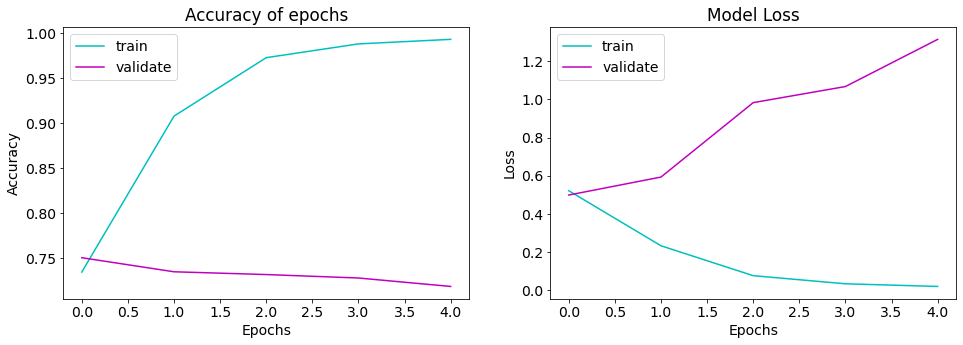

In [93]:
plot_model(history_6)

In [94]:
result_6 = pd.DataFrame((score_train6[1], score_test6[1], score_train6[0], score_test6[0])).T
result_6.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_6['model'] = 'CNN + LSTM'

### GRU + CNN

In [145]:
model_15 = Sequential([
    layers.Embedding(input_dim=word_count, output_dim=embedding_dim, input_length=training_length),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.LSTM(64),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [146]:
model_15.compile(optimizer='RMSprop',
                     loss='huber_loss',
                     metrics=['accuracy'])

In [147]:
start_time = time.time()
history_15 = model_15.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_val))
model_time7 = (time.time() - start_time)

Epoch 1/5
1744/2836 [=================>............] - ETA: 2:14 - loss: 0.1032 - accuracy: 0.6641

KeyboardInterrupt: 

In [ ]:
model_time7

In [ ]:
score_train7 = model_14.evaluate(X_train, y_train, verbose=0)
score_test7 = model_14.evaluate(X_valid, y_val, verbose=0)

In [ ]:
print('Train loss:', score_train7[0]) # SGD  epochs - 15
print('Train accuracy:', score_train7[1])
print('Test loss:', score_test7[0])
print('Test accuracy:', score_test7[1])

In [94]:
print('Train loss:', score_train7[0]) # 600 Adamax epochs - 15
print('Train accuracy:', score_train7[1])
print('Test loss:', score_test7[0])
print('Test accuracy:', score_test7[1])

Train loss: 0.016201043501496315
Train accuracy: 0.9952112436294556
Test loss: 1.5326347351074219
Test accuracy: 0.7227879762649536


In [71]:
print('Train loss:', score_train7[0]) # 2389.518482208252 Nadam
print('Train accuracy:', score_train7[1])
print('Test loss:', score_test7[0])
print('Test accuracy:', score_test7[1])

Train loss: 0.009484490379691124
Train accuracy: 0.9973383545875549
Test loss: 1.3493622541427612
Test accuracy: 0.7296653985977173


In [59]:
print('Train loss:', score_train7[0]) # 1502.3536627292633 RMSprop 
print('Train accuracy:', score_train7[1])
print('Test loss:', score_test7[0])
print('Test accuracy:', score_test7[1])

Train loss: 0.12452183663845062
Train accuracy: 0.9594085812568665
Test loss: 0.6603128910064697
Test accuracy: 0.7361019253730774


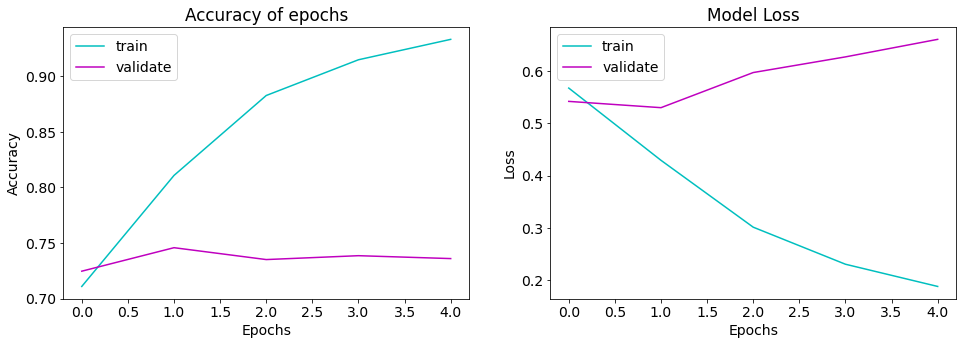

In [60]:
plot_model(history_7)

In [61]:
result_7 = pd.DataFrame((score_train7[1], score_test7[1], score_train7[0], score_test7[0])).T
result_7.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_7['model'] = 'GRU + CNN'

### Results

In [96]:
final_results = pd.concat([baseline_lr, baseline_lsvc, result_1, result_2, result_3, result_4, result_5, result_6], axis=0)

In [97]:
final_results.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy,train_loss,test_loss
0,CountVectorizer_LR,0.90714,0.74064,NaN,NaN
1,TfidfVectorizer_LSVC,0.96288,0.73884,NaN,NaN
2,HashingVectorizer_LSVC,0.93230,0.73791,NaN,NaN
1,TfidfVectorizer_LR,0.84481,0.73703,NaN,NaN
0,CountVectorizer_LSVC,0.97984,0.72764,NaN,NaN
2,HashingVectorizer_LR,0.80847,0.72636,NaN,NaN
0,CNN,0.99901,0.72041,0.00309,1.41303
0,Add Dropout,0.99803,0.71975,0.00647,1.17763
0,CNN + LSTM,0.99702,0.71856,0.00839,1.31449
0,Embedding Layer,0.99792,0.71088,0.00696,1.14392


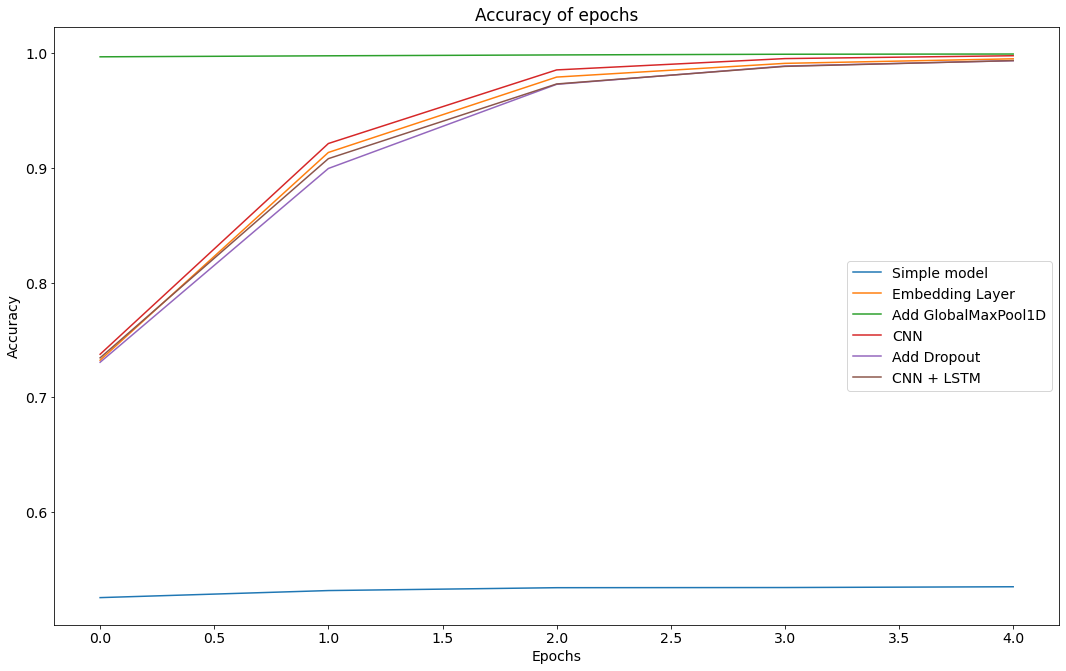

In [100]:
plt.figure(figsize=(18, 11))
plt.plot(history_1.history['accuracy'], label='Simple model')
plt.plot(history_2.history['accuracy'], label='Embedding Layer')
plt.plot(history_3.history['accuracy'], label='Add GlobalMaxPool1D')
plt.plot(history_4.history['accuracy'], label='CNN')
plt.plot(history_5.history['accuracy'], label='Add Dropout')
plt.plot(history_6.history['accuracy'], label='CNN + LSTM')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

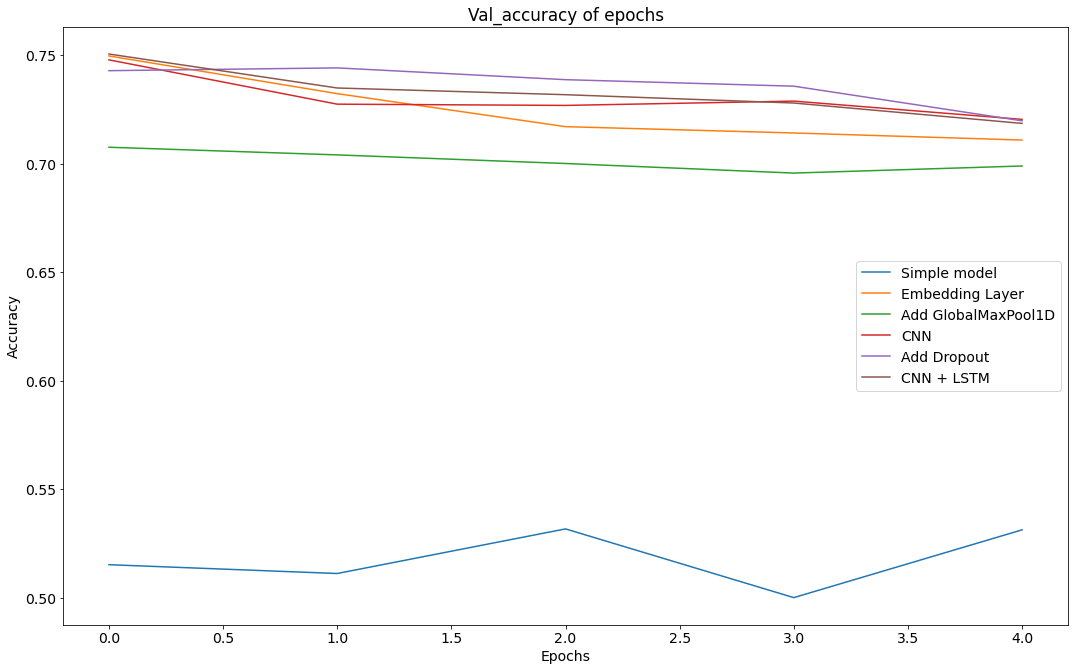

In [101]:
plt.figure(figsize=(18, 11))
plt.plot(history_1.history['val_accuracy'], label='Simple model')
plt.plot(history_2.history['val_accuracy'], label='Embedding Layer')
plt.plot(history_3.history['val_accuracy'], label='Add GlobalMaxPool1D')
plt.plot(history_4.history['val_accuracy'], label='CNN')
plt.plot(history_5.history['val_accuracy'], label='Add Dropout')
plt.plot(history_6.history['val_accuracy'], label='CNN + LSTM')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Val_accuracy of epochs')
plt.show()